<a href="https://colab.research.google.com/github/TheDandyCodes/Deep-Learning/blob/main/Unit_2/GAN/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PEC1 - Generative Adversarial Networks
A partir del conjunto de datos CIFAR10, se debe entrenar una *DCGAN* (*Deep Convolutional Generative Adversarial Network*) para generar nuevas imágenes. Una vez implementada la red, se deberá agregar *experience replay* y comparar los resultados con los obtenidos en la red inicial. Por último, se deberá convertir la red en una GAN condicional.

## Instrucciones
Se debe contestar a cada apartado de la práctica en el espacio correspondiente de esta plantilla. Los apartados que se deben contestar en lenguaje natural (utilizando las celdas de tipo Markdown), se han resaltado en amarillo. Se debe añadir debajo del texto resaltado la respuesta correspondiente. Cuando el texto subrayado indique algún requisito de la respuesta (por ejemplo en cuanto a longitud de la respuesta), será imprescindible ajustarse a dicho requisito. Los apartados que requieren código en Python deberán contestarse en los espacios de código previstos para ello. Al igual que las respuestas en celdas de tipo markdown, las respuestas de código pueden tener asociados requisitos especiales. Estos espacios se delimitan con la siguiente estructura:
``` python
# INICIO_RESPUESTA
# Requisitos: Elabore una función que siempre devuelva True

def mi_funcion() :
    return True

# FIN_RESPUESTA
```

## Esquema de la plantilla
El esquema de la memoria deberá ser el siguiente:

1. Explicar qué es una *DCGAN* y cómo funciona (haciendo énfasis en explicar las dos partes principales de este tipo de modelos)
1. Describir brevemente el conjunto de datos inicial (*CIFAR10*)
1. Entrenar una *DCGAN (Deep Convolutional Generative Adversarial Network)* para generar imágenes.
1. Añadir *experience replay*
1. Convertir la red a una *GAN condicional*

En primer lugar vamos a cargar las librerías y funciones de apoyo que se van a utilizar en el código del cuadernillo. Si se quiere utilizar alguna librería adicional se puede añadir dicha librería en este punto o en la celda de código en la que se vaya a utilizar por primera vez.


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
assert tf.__version__ >= "2.0"
from tensorflow import keras

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Reshape, Conv2D, BatchNormalization, Conv2DTranspose, LeakyReLU, Flatten, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam

import sklearn
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Check for GPU
!nvidia-smi

print("GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Fri Apr  4 08:31:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   63C    P8             11W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Consideraciones iniciales

Dado el tiempo de cómputo que exigen este tipo de redes se limitará el análisis de 50 epochs. Es muy recomendable, también que, si no se dispone de una tarjeta gráfica y una configuración compatible con tensorflow (puede comprobarse con la última salida del bloque anterior, si el número de GPUs disponible es 0) se utilice para la realización de esta práctica Google Colab. En este plataforma deberemos configurar el entorno de ejecución para que soporte GPUs, esto puede hacerse a través del menú *Entorno de ejecución* y la opción *Cambiar tipo de entorno de ejecución*, selecconando **GPU** como *Acelerador por hardware* .

In [3]:
# Definimos las constantes que utilizaremos a lo largo del cuadernillo
batch_size = 128
epochs = 50
latent_dim = 100

Es importante saber que para poder depurar algunos métodos como «fit» debemos cambiar el modo de ejecución. Para ello podemos dar el valor «True» al parámetro «run_eagerly» cuando compilemos el modelo. Cuidado, al cambiar este parámetro la ejecución del código será mucho más lenta. Para más información y consejos de depuración se recomienda utilizar los consejos que se indican en la propia página de Keras (https://keras.io/examples/keras_recipes/debugging_tips/)

## Memoria
**Nombre:** <mark>Ricardo Prieto Álvarez</mark>

**Correo UNED:** <mark>rprieto291@alumno.uned.es</mark>

### ¿Qué es una DCGAN?
<mark>\[Respuesta: Explicar lo que es una DCGAN, extensión aproximada de 2 párrafos (200 palabras) \]</mark>

Las DCGAN son una variante avanzada de las GAN que utilizan redes neuronales convolucionales profundas en lugar de las redes totalmente conectadas empleadas en las GAN tradicionales. Funcionan mediante dos componentes en competencia: un generador, que toma una señal de ruido aleatorio y la transforma en imágenes sintéticas, y un discriminador, encargado de clasificar las imágenes como reales o falsas. Esta arquitectura fue desarrollada para mejorar significativamente la calidad de las imágenes generadas, siguiendo el modelo de "falsificador y policía", donde ambas redes mejoran progresivamente a través de su competencia mutua.

A diferencia de las GAN convencionales, las DCGAN presentan características específicas que optimizan la generación de imágenes: eliminan las capas de pooling para evitar la pérdida de detalles importantes, implementan capas de normalización por lotes para estabilizar el entrenamiento, y utilizan funciones de activación específicas (ReLU en el generador y LeakyReLU en el discriminador). El generador emplea capas de convolución transpuesta que aumentan gradualmente la resolución de la imagen mientras reducen la cantidad de canales, culminando con una función de activación tangente hiperbólica en la capa final para producir imágenes de alta calidad. Esta arquitectura ha demostrado ser particularmente efectiva para generar imágenes realistas que pueden utilizarse en diversos campos como el diseño, videojuegos o para ampliar conjuntos de datos de entrenamiento para otras redes neuronales.


### CIFAR10
CIFAR10 Contiene 60000 imágenes a color de baja resolución (32x32 píxeles) distribuidas en 10 clases: aviones, automóviles, pájaros, gatos, ciervos, perros, ranas, caballos, barcos y camiones. Cada clase incluye 6000 imágenes, divididas en 50000 para entrenamiento y 10000 para pruebas

In [4]:
# En primer lugar vamos a descargar el conjunto de datos
(X_train, Y_train), (X_test, Y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [5]:
# INICIO_RESPUESTA 0/7
# Requisitos: De como valor de la variable «semilla_aleatoria» los últimos dos dígitos de su documento de identificación
semilla_aleatoria = 76
# FIN_RESPUESTA

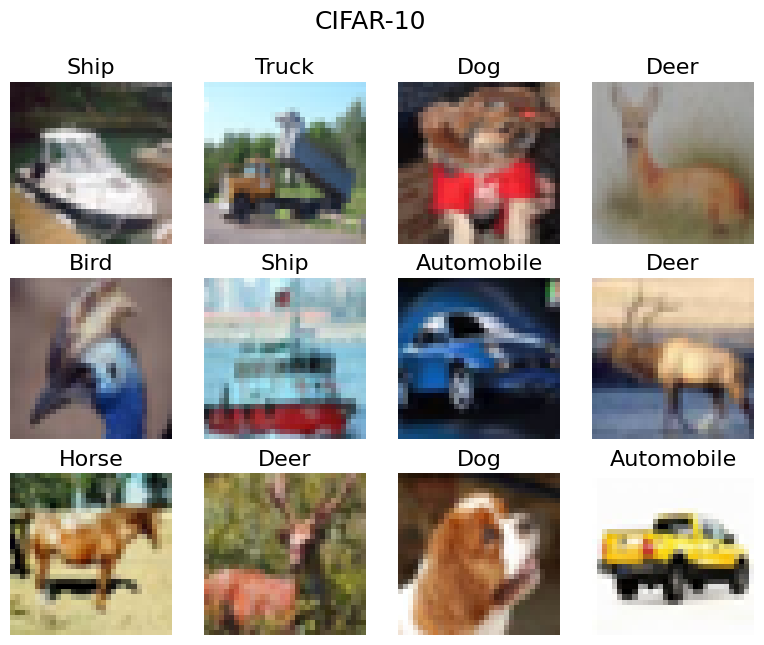

In [6]:
np.random.seed(semilla_aleatoria)
tf.random.set_seed(semilla_aleatoria)

# Vamos a visualizar un subconjunto de las imagenes que hemos cargado
clases = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
plt.figure(figsize=(9.6,7.2))
plt.suptitle("CIFAR-10", size=18)
plt.subplots_adjust(wspace=0.2)

pos = 1
for n in np.random.randint(low=0,high=len(X_train),size=12):
    plt.subplot(3, 4, pos)
    plt.imshow(X_train[n])
    plt.axis('off')
    plt.title(clases[Y_train[n][0]], size=16)
    pos += 1
plt.show()

### Pre-procesado de datos
<mark>\[Respuesta: Describir los pasos de preprocesado que se han realizado así como la justificación de los mismos (tener en cuenta que se utilizará la función de activación tangencial hipèrbólica)\]</mark>

Las imágenes de CIFAR10 tienen estan formadas por tenesores de 32x32x3, es decir, se trata de imagenes de 32 pixeles de ancho, 32 de alto y 3 canales.

Dado que la función de activación del Generador es una `tanh`, es necesario aplciar una normalización de las imagenes, de tal manera que estén en el rango [-1,1]. Para conseguir esto, se dividen los pixeles entre 255 y se multiplica por 2, para después restar 1.

Esto es crítico debido a que:

El generador de la DCGAN utiliza `tanh` como función de activacióin de su capa final; función que produce salidas en [-1,1].

Para un entrenamiento estable del modelo, es recomendado alinear el rango de las imágenes reales con las generadas.

In [7]:
# Dado que no tendremos una estructura de entrenamiento y validación, vamos a juntar todos las imágenes
all_imgs = np.concatenate([X_train, X_test])
all_labels = np.concatenate([Y_train, Y_test])

# INICIO_RESPUESTA 1/7
# Requisitos: Realice el pre-procesado de los datos de entrada teniendo en cuenta las recomendaciones que se indican en el capítulo 17 del libro, guarde el resultado en all_imgs.
all_imgs = all_imgs / 255.0 * 2 - 1
# FIN_RESPUESTA

In [8]:
print(all_imgs.min())
print(all_imgs.mean())
print(all_imgs.max())

-1.0
-0.052200025658701014
1.0


### DCGAN Inicial
En este apartado se quiere crear una primera red usando la API secuencial de Keras.  Es importante en este punto revisar las recomendaciones que se presentan en el capítulo 17 del libro:

<mark>\[Respuesta: Describir las recomendaciones que se presentan en el capítulo 17 del libro. Si, tras la evaluación de estas recomendaciones se detectan inconsistencias o no se siguen todas, indicar por qué.\]</mark>

Las recomendaciones para construir una arquitectura DCGAN son:

**Generador**
- Capas Convolucionales Traspuestas de Stride=2. Esto provoca un _upsampling_ del input de entrada; las imágenes en este caso.
- Batch Normalization en todas las capas, excepto en la de salida.
- Función de activación `ReLU` en las capas ocultas y `tanh` en la capa de salida
Se observa la presencia de una convolución final no traspuesta, lo que supone un downsampling.

**Discriminador**
- Capas Convolucionales de Stride=2. Esto provoca un _downsampling_ del input de entrada
- `LeakyReLU` (con pendiente=0.2) en lugar de `ReLU` para evitar gradientes nulos
- Batch Normalization en todas las capas, excepto en la de entrada.
- Sin capas totalmente conectadas intermedias; salida con una neurona sigmoide

Sin embargo, la arquitectura propuesta en el enunciado no cumple con lo siguiente:

**Generador**
- Se añade una Capa Convolucional después de las Capas de Convolución Traspuestas
- Se utiliza la función de activación `Leaky ReLU` para las Capas Convolucionales Traspuestas, en vez de `ReLU`

**Discriminador**:
- Se añade tanto Batch Normalization como Dropout como metodo de regulación. Las recomendaciones indican el uso de uno u otro.

#### Generador

Para el generador se utilizará la siguiente estructura:

1. Capa densa y reshape a 8 x 8 x 128
2. Capa de convolución transpuesta con 64 filtros (kernel de 4x4, 2 strides y padding 'same')
3. Capa de convolución transpuesta con 64 filtros (kernel de 4x4, 2 strides y padding 'same')
4. Capa convolucional con 3 filtros (kernel de 3x3, 1 stride, padding 'same' y función de activación 'tanh')

Todas las capas convolucionales transpuestas tienen una función de activación Leaky ReLU (únicamente las transpuestas) y, tras cada capa se aplicará normalización por lotes (BatchNormalization).

In [ ]:
generator = keras.models.Sequential([
    keras.layers.Input(shape=(latent_dim,)),

# INICIO_RESPUESTA 2/
# Requisitos: Añada las capas indicadas para el generador
    Dense(8 * 8 * 128),
    Reshape((8, 8, 128)),
    BatchNormalization(),

    Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
    BatchNormalization(),
    LeakyReLU(alpha=0.2),

    Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
    BatchNormalization(),
    LeakyReLU(alpha=0.2),

    Conv2D(3, kernel_size=3, strides=1, padding="same", activation="tanh")
# FIN_RESPUESTA
])

generator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 8192)                │         827,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 64)          │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 64)          │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 3)           │           1,731 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,026,883 (3.92 MB)

 Trainable params: 1,026,371 (3.92 MB)

 Non-trainable params: 512 (2.00 KB)

#### Discriminador

Para el Discriminador se utilizará la siguiente estructura:

1. Capa convolucional con 32 filtros (kernel de 4x4, 2 strides y padding 'same')
2. Capa convolucional con 64 filtros (kernel de 4x4, 2 strides y padding 'same')
3. Capa convolucioanl con 128 filtros (kernel de 4x4, 2 strides y padding 'same')
4. Capa Densa con función de activación sigmoide

Todas las capas convolucionales tienen una función de activación Leaky ReLU y, posteriormente se aplicarán normalización (BatchNormalization) y Dropout. Salvo la última capa convolucional que no aplicará normalización si no que aplanará el resultado de cara a la última capa densa.

In [ ]:
discriminator = keras.models.Sequential([
# INICIO_RESPUESTA 3/7
# Requisitos: Añada las capas indicadas para el discriminador
    keras.layers.Input(shape=(32, 32, 3)),

    Conv2D(32, kernel_size=4, strides=2, padding="same"),
    LeakyReLU(alpha=0.2),
    BatchNormalization(),
    Dropout(0.2),

    Conv2D(64, kernel_size=4, strides=2, padding="same"),
    LeakyReLU(alpha=0.2),
    BatchNormalization(),
    Dropout(0.2),

    Conv2D(128, kernel_size=4, strides=2, padding="same"),
    LeakyReLU(alpha=0.2),
    Flatten(),
    Dense(1, activation='sigmoid')
# FIN_RESPUESTA
])

discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 16, 16, 32)          │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_12 (LeakyReLU)           │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 16, 16, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 8, 8, 64)            │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_13 (LeakyReLU)           │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 4, 4, 128)           │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_14 (LeakyReLU)           │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 168,033 (656.38 KB)

 Trainable params: 167,841 (655.63 KB)

 Non-trainable params: 192 (768.00 B)

#### Modelo
<mark>\[Respuesta: Explicar los pasos de entrenamiento de una GAN, diferenciando el proceso de entrenamiento del generador y del discriminador. \]</mark>

**Entrenamiento del Discriminador**

El discriminador se entrena para distinguir entre datos reales y generados. Los pasos son:

Paso 1: Crear un batch de datos reales.
- Selecciona un conjunto de muestras reales del dataset. Deben estar etiquetadas con la clase "1" (reales).

Paso 2: Generar datos falsos
- Genera un batch de datos sintéticos con el generador. Deben estar etiquetadas con la clase "0" (falsos).

Paso 3: Entrenar el discriminador
- Combina los datos reales y falsos en un único batch y se calcula la pérdida del discriminador usando una función como `binary cross-entropy`, comparando las predicciones con las etiquetas reales ("1" para datos reales, "0" para datos falsos).

Nota: En esta fase de entrenamiento, la retropropagación solo optimiza los pesos del descriminador.

**Entrenamiento del Generador**

El generador se entrena para engañar al discriminador, haciendo que clasifique las muestras falsas como reales. Los pasos son:

Paso 1: Generar ruido aleatorio

- Crea un batch de vectores de ruido aleatorio

Paso 2: Generar datos sintéticos

- Usa el generador para producir datos sintéticos
G(z)

Paso 3: Engañar al discriminador

- Pasa las muestras generadas G(z) al discriminador. Etiqueta estas muestras como "1" (reales), aunque sean falsas.

Paso 4: Calcular la pérdida del generador

- La pérdida del generador mide qué tan bien logró engañar al discriminador. Por ejemplo, si se usa `binary cross-entropy`, la pérdida sería alta si el discriminador detectó que los datos eran falsos, y baja si fue engañado.

Paso 5: Actualizar los pesos del generador

- Usa retropropagación para actualizar los pesos del generador, minimizando su pérdida.

Nota: Los pesos del discriminador están congelados en esta fase de entrenamiento, por lo tanto, la retropropagación solo afecta a los pesos del generador.


In [9]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        generated_images = self.generator(random_latent_vectors)

        # Cast real_images to float32 to match generated_images
        # and avoid TypeError between [float32, float64]
        real_images = tf.cast(real_images, dtype=tf.float32)

        combined_images = tf.concat([generated_images, real_images], axis=0)

        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)

        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100, show_range=10, enable_show=True, enable_save=False):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.show_range = show_range
        self.enable_show = enable_show
        self.enable_save = enable_save

    def on_epoch_end(self, epoch, logs=None):
        if ((epoch+1) % self.show_range) == 0 or epoch == 0:
          random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
          generated_images = self.model.generator(random_latent_vectors)
          generated_images += 1
          generated_images /= 2

          generated_images.numpy()
          plt.figure(figsize=(self.num_img, 1))
          for i in range(self.num_img):
              img = keras.preprocessing.image.array_to_img(generated_images[i])
              if self.enable_show:
                plt.subplot(1, self.num_img, i + 1)
                plt.imshow(img, cmap="binary")
                plt.axis("off")
              if self.enable_save:
                img.save("generated_img_%03d_%d.png" % (epoch, i))
          if self.enable_show:
            plt.show()

In [10]:
def plt_loss(history):
    '''
    Función que nos ayudará a visualizar la evolución de las pérdidas del generador y del discriminador
    '''
    f_num = "{:.3f}"
    plt.figure(figsize=(12,5))
    plt.suptitle("Función de pérdida", size=18)
    plt.subplots_adjust(wspace=0.5, hspace = 0.5)
    plt.subplot(1, 2, 1)
    plt.plot(history.history['d_loss'])
    plt.title("Discriminador")
    plt.ylabel('Loss')
    plt.xlabel('Epoch')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['g_loss'])
    plt.title("Generador")
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.tight_layout(pad=4)
    plt.show()
    print(f"Pérdida discriminador: Min ({f_num.format(np.min(history.history['d_loss']))}) Max ({f_num.format(np.max(history.history['d_loss']))}) Media ({f_num.format(np.mean(history.history['d_loss']))})")
    print(f"Pérdida generador: Min ({f_num.format(np.min(history.history['g_loss']))}) Max ({f_num.format(np.max(history.history['g_loss']))}) Media ({f_num.format(np.mean(history.history['g_loss']))})")

#### Optimizadores y función de pérdida
<mark>\[Respuesta: Explicar qué optimizadores se utilizarán para el discriminador y el generador y por qué. \]</mark>

Se utiliza el optimizador Adam tanto para el discriminador como para el generador. Esto intenta asegurar que ambas redes evolucionen a un ritmo comparable. La opción de aplicar optimizadores distintos para el Generador y para el Discriminador fomenta un riesto de desequilibrio, donde si el Discriminador converge más rapido que el Generador (o viceversa), el entrenamiento colapsaría.

Para el optimizador se seleccionan los siguientes hiperparámetros:
- **Learning rate**: 0.0002. Este valor es óptimo para evitar oscilaciones.
- **Beta 1 (momentum)**: 0.5 en vez de 0.9, para reducir inestabilidad.

Fuentes:
- https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/
- https://dropsofai.com/best-practices-for-training-stable-gans/

In [11]:
# INICIO_RESPUESTA 4/7
# Requisitos: Inicialice los optimizadores que se utilizarán para el discriminador y para el generador, se aconseja utilizar valores LR de aproximadamente 0.0002
d_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
g_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
# FIN_RESPUESTA

loss_fn = keras.losses.BinaryCrossentropy()

In [12]:
dataset = tf.data.Dataset.from_tensor_slices(all_imgs).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Epoch 1/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.4388 - g_loss: 1.6854

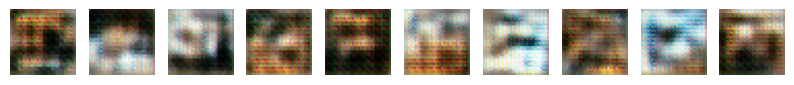

468/468 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - d_loss: 0.4390 - g_loss: 1.6850
Epoch 2/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - d_loss: 0.6725 - g_loss: 0.8858
Epoch 3/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - d_loss: 0.6836 - g_loss: 0.8107
Epoch 4/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - d_loss: 0.6771 - g_loss: 0.8095
Epoch 5/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - d_loss: 0.6880 - g_loss: 0.7774
Epoch 6/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - d_loss: 0.6881 - g_loss: 0.7692
Epoch 7/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - d_loss: 0.6868 - g_loss: 0.7772
Epoch 8/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - d_loss: 0.6891 - g_loss: 0.7837
Epoch 9/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - d_loss: 0.6901 - g_loss: 0.7804
Epoch 10/50
466/468 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.6870 - g_loss: 0.7839

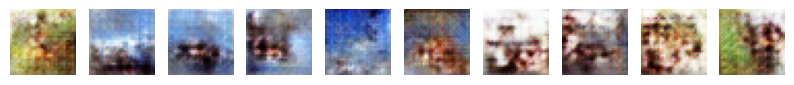

468/468 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - d_loss: 0.6870 - g_loss: 0.7839
Epoch 11/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - d_loss: 0.6896 - g_loss: 0.7900
Epoch 12/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - d_loss: 0.6835 - g_loss: 0.8024
Epoch 13/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - d_loss: 0.6790 - g_loss: 0.8171
Epoch 14/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - d_loss: 0.6774 - g_loss: 0.8230
Epoch 15/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - d_loss: 0.6753 - g_loss: 0.8398
Epoch 16/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - d_loss: 0.6732 - g_loss: 0.8316
Epoch 17/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - d_loss: 0.6731 - g_loss: 0.8349
Epoch 18/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - d_loss: 0.6722 - g_loss: 0.8312
Epoch 19/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - d_loss: 0.6762 - g_loss: 0.8136
Epoch 20/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.6794 - g_loss: 0.8030

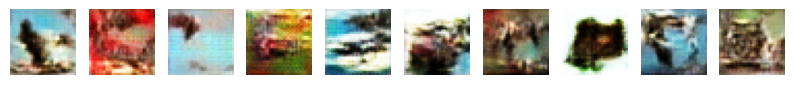

468/468 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - d_loss: 0.6794 - g_loss: 0.8030
Epoch 21/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - d_loss: 0.6795 - g_loss: 0.8015
Epoch 22/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - d_loss: 0.6807 - g_loss: 0.7962
Epoch 23/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - d_loss: 0.6805 - g_loss: 0.7984
Epoch 24/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - d_loss: 0.6777 - g_loss: 0.7980
Epoch 25/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - d_loss: 0.6793 - g_loss: 0.8081
Epoch 26/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - d_loss: 0.6758 - g_loss: 0.8080
Epoch 27/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - d_loss: 0.6751 - g_loss: 0.8045
Epoch 28/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - d_loss: 0.6746 - g_loss: 0.8211
Epoch 29/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - d_loss: 0.6734 - g_loss: 0.8270
Epoch 30/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.6713 - g_loss: 0.8257

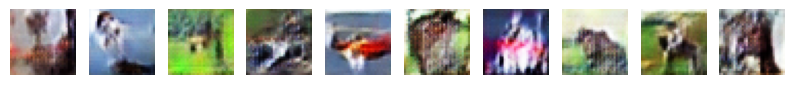

468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - d_loss: 0.6713 - g_loss: 0.8257
Epoch 31/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - d_loss: 0.6662 - g_loss: 0.8159
Epoch 32/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - d_loss: 0.6696 - g_loss: 0.8282
Epoch 33/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - d_loss: 0.6679 - g_loss: 0.8194
Epoch 34/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - d_loss: 0.6713 - g_loss: 0.8216
Epoch 35/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - d_loss: 0.6717 - g_loss: 0.8192
Epoch 36/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - d_loss: 0.6700 - g_loss: 0.8140
Epoch 37/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - d_loss: 0.6698 - g_loss: 0.8098
Epoch 38/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - d_loss: 0.6699 - g_loss: 0.8164
Epoch 39/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - d_loss: 0.6696 - g_loss: 0.8127
Epoch 40/50
467/468 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.6688 - g_loss: 0.8165

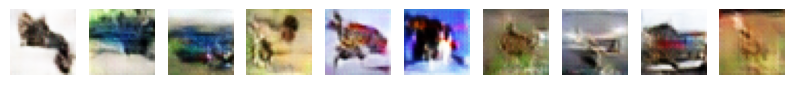

468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - d_loss: 0.6688 - g_loss: 0.8165
Epoch 41/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - d_loss: 0.6689 - g_loss: 0.8185
Epoch 42/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - d_loss: 0.6674 - g_loss: 0.8140
Epoch 43/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - d_loss: 0.6649 - g_loss: 0.8208
Epoch 44/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - d_loss: 0.6650 - g_loss: 0.8293
Epoch 45/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - d_loss: 0.6645 - g_loss: 0.8321
Epoch 46/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - d_loss: 0.6625 - g_loss: 0.8304
Epoch 47/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - d_loss: 0.6617 - g_loss: 0.8269
Epoch 48/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - d_loss: 0.6608 - g_loss: 0.8340
Epoch 49/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - d_loss: 0.6605 - g_loss: 0.8353
Epoch 50/50
466/468 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.6574 - g_loss: 0.8387

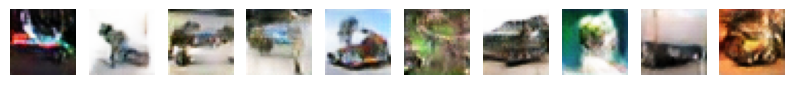

468/468 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - d_loss: 0.6574 - g_loss: 0.8387


In [ ]:
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=d_optimizer,
    g_optimizer=g_optimizer,
    loss_fn=loss_fn,
)

history = gan.fit(dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)])

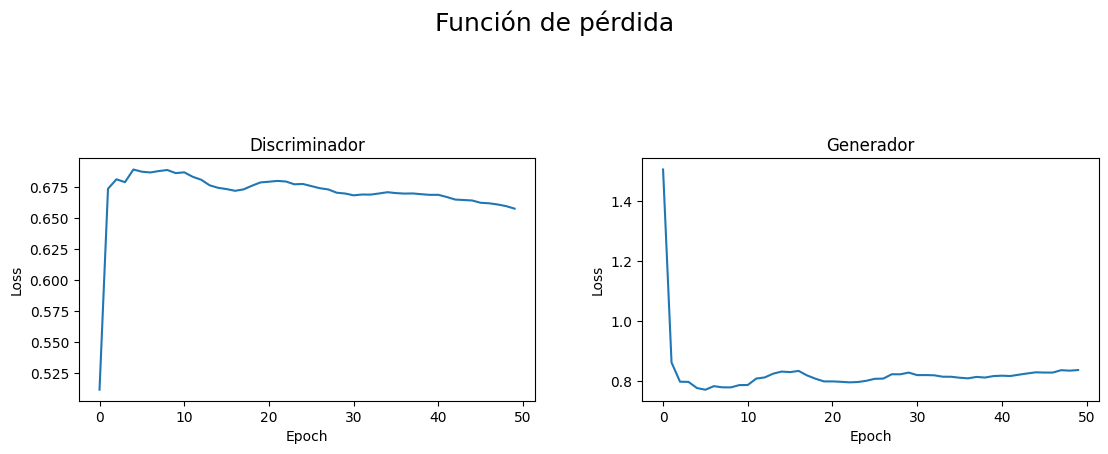

Pérdida discriminador: Min (0.512) Max (0.689) Media (0.671)
Pérdida generador: Min (0.773) Max (1.505) Media (0.827)


In [ ]:
plt_loss(history)

#### Resultados
<mark>\[Respuesta: Explicar los resultados obtenidos visualizando la evolución de las pérdidas del discriminador y del generador. \]</mark>

De manera global, se observa que cuando uno de los modelos mejora, el otro modelo también mejora, o más bien, no empeora.

Los valores de pérdida no se disparan en ninguno de los dos modelos, lo que indica que el entrenamiento es estable y no está desequilibrado.

**Discriminador**

Después del pico inicial, la curva se estabiliza con valores entre 0.65-0.69. A medida que evoluciona el entrenamiento, el valor de la pérdida tiende a bajar sutilmente. Esto sugiere que el discriminador está aprendiendo a discernir entre imágenes reales y falsas (aunque no de manera perfecta)

**Generador**

Al principio la pérdida es alta. Esto es normal, ya que el generador al principio no sabe como transformar ruido aleatorio en imagenes realistas, por lo tanto, el discriminador las rechaza con facilidad.

Este _Loss_ desciende abruptamente a partir de la _epoch_ 5, lo que indica que el generador ha aprendido a generar imágenes que puedan no ser detectadas como falsas por el discriminador. Esto se mantiene de manera ligeramente estable entre valores de 0.5-0.9.



### Experience replay
<mark>\[Respuesta: Explicar en qué consiste la técnica de *Experience replay* y qué resultados se esperan de su uso. \]</mark>

La técnica de _Experience Replay_ busca romper la correlación temporal entre muestras secuenciales y mejorar la eficiencia del entrenamiento. La implementaciín de _Experience Replay_ en DCGAN tiene efectos específicos en la estabilidad y calidad del aprendizaje del discriminador.

Durante el entrenamiento, se guardan muestras generadas por el generador en un búfer de capacidad fija.

En cada iteración, se selecciona un subconjunto de experiencias (imágenes) almacenadas (tanto recientes como antiguas) para entrenar al discriminador, combinándolas con muestras reales.

Al utilizar datos históricos, se evita que el discriminador se sobreajuste a las últimas salidas del generador, fomentando un equilibrio dinámico más estable. Esto es gracias a que, al entrenar al discriminador con imágenes sintéticas de diferentes etapas del generador (no solo las últimas), se rompen patrones locales específicos que el generador podría explotar cíclicamente

**Resultados esperados**:

Al exponer al discriminador a variedad de muestras históricas, se fuerza al generador a producir mayor diversidad de salidas, evitando también el colapso del entrenamiento.

El muestreo aleatorio reduce las oscilaciones que pueden producirse en los gradientes.

<mark>\[Respuesta: Explicar qué estrategia de *Experience replay* (de las muchas posibles) se ha implementado en el modelo que hay a continuación. \]</mark>

La estrategía implementada corresponde a entrenar al discriminador en dos fases dentro de la misma iteración. Primero se entrena usando las imágenes actuales (generadas y reales) y, después, se realiza una actualización extra usando un mini‐batch extraído del buffer (que contiene imágenes generadas en iteraciones previas).

El proceso es el siguiente:

Inmediatamente después de actualizar el discriminador con las imágenes actuales, se itera sobre las imágenes generadas y se añaden al buffer de _Experience replay_. El buffer estña limitado a un número máximo de imágenes que lo componen. En el caso de que el buffer supere este tamaño, se retienen las últimas imágenes almacenadas.

A continuación, se extrae una muestra de imágenes aleatorias del buffer (del mismo tamaño que el batch actual, o menor si el buffer es pequeño) y se calcula la pérdida (`replay_loss`) utilizando estas imágenes y las etiquetas correspondientes. Luego, se aplican los gradientes para actualizar nuevamente el discriminador.

#### Modelo

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim, max_buffer_size = 50):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.experience_replay = []
        self.max_buffer_size = max_buffer_size

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        generated_images = self.generator(random_latent_vectors)

        # Cast real_images to float32 to match generated_images
        # and avoid TypeError between [float32, float64]
        real_images = tf.cast(real_images, dtype=tf.float32)

        combined_images = tf.concat([generated_images, real_images], axis=0)

        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # INICIO_RESPUESTA 5/7
        # Requisitos: Implementar una estrategia de Experience replay a partir de un buffer de imágenes alamacenadas en cada iteració

        # Agregar imágenes generadas al buffer
        self.experience_replay += tf.unstack(generated_images)

        # Se aplica una limitación del tamaño máximo del buffer
        if len(self.experience_replay) > self.max_buffer_size:
            self.experience_replay = self.experience_replay[-self.max_buffer_size:]

        import random
        replay_batch_size = min(int(real_images.shape[0]), len(self.experience_replay))
        if replay_batch_size > 0:
            replay_indices = random.sample(range(len(self.experience_replay)), replay_batch_size)
            replay_images = tf.stack([self.experience_replay[i] for i in replay_indices], axis=0)
            replay_labels = tf.ones((replay_batch_size, 1))
            replay_labels += 0.05 * tf.random.uniform(tf.shape(replay_labels))
            with tf.GradientTape() as tape:
                replay_predictions = self.discriminator(replay_images)
                replay_loss = self.loss_fn(replay_labels, replay_predictions)
            replay_grads = tape.gradient(replay_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(zip(replay_grads, self.discriminator.trainable_weights))
        # FIN_RESPUESTA

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [ ]:
gan_er = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan_er.compile(
    d_optimizer=d_optimizer,
    g_optimizer=g_optimizer,
    loss_fn=loss_fn,
)

history = gan_er.fit(dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)])

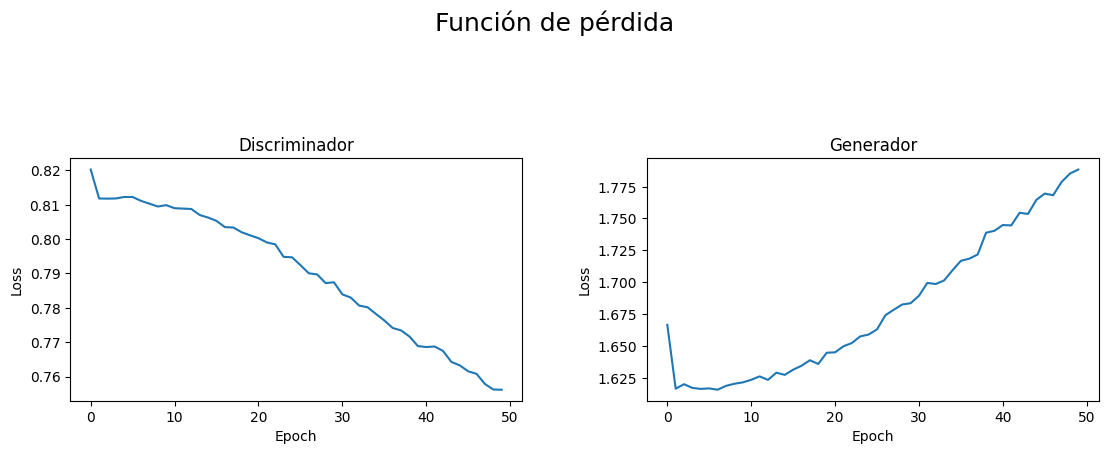

Pérdida discriminador: Min (0.756) Max (0.820) Media (0.790)
Pérdida generador: Min (1.616) Max (1.788) Media (1.679)


In [ ]:
plt_loss(history)

#### Resultados
<mark>\[Respuesta: Explicar los resultados obtenidos visualizando y compararlos con los obtenidos en la GAN sin *Experience replay*. \]</mark>

La principal diferencia respecto a la GAN sin - Experience replay_ es que ahora el discriminador se fortalece más y más al ver muestras antiguas y recientes, mientras el generador sufre para adaptarse a un discriminador que “no olvida”. Esto se traduce en una pérdida del discriminador cada vez más baja y una pérdida del generador creciente, a diferencia del entrenamiento estándar en el que ambas pérdidas tienden a estabilizarse en valores más equilibrados.

La pérdida del Discriminador comienza en valores de 0.82 y desciende gradualmente hasta  menos de 0.76. Esto indica que el Discriminador cada vez es más eficaz para discernir entre imagenes sintéticas y reales

La perdida del Generador, sin embargo, aumenta gradualmente de 1.60 hasta 1.77. Esto da a entender que el Generador está teniendo más dificultad en "engañar" al descriminador con las imagenes generadas. Esto es debido a que el discriminador tiene a memorizar debido a esta estrategia de _Experience Replay_

En algunos casos, esto puede llevar a un estancamiento del generador (no logra mejorar lo suficiente), como parace pasar en nuestro caso.

Sin embargo, en términos de estabilidad, usar _Experience Replay_ puede evitar la “catástrofe del olvido” en el discriminador y ayudar a capturar mejor la variedad de ejemplos que produce el generador a lo largo del tiempo.

Para corregir este posible desequilibrio, se puede probar con diferentes hiperparámetros como el tamaño del buffer o tasa de aprendizaje.

### GAN condicional
<mark>\[Respuesta: Explicar en qué consisten las GAN condicionales y qué resultados se esperan de estos modelos en relación al modelo original y al modelo con *Experience replay*. \]</mark>

Las GAN condicionales son una variante de las GAN tradicionales que incorporan información adicional como etiquetas o descriptores para controlar la generación de datos. A diferencia de las GAN originales que producen resultados aleatorios, permiten dirigir la creación de muestras específicas mediante condiciones externas.

Los resultados esperados enc omparación con el modelo base y el _Experience replay_ es la generación dirigida.

Este tipo de GANs mantienen su ventaja en aplicaciones que demandan una generación dirigida, mientras el _Experience Replay_ mejoraría aspectos de estabilidad.

#### Discriminador
<mark>\[Respuesta: Explicar las adaptaciones que necesitará el discriminador para realizar la discriminación basado en la clase. \]</mark>

En este caso, al tener múltiples entradas (imagen y etiqueta) necesitamos procesar la etiqueta por separado antes de combinarla con la imagen, por lo tanto, la estructura ya no es puramente secuencial debido a la concatenación. Por esto mismo se vuelve necesario utilizar la API Funcional de Keras.

Primero, la etiqueta de entrada corresponde a un vector de One-Hot encoding (shape (10,)), después se pasará a través de una capa densa de 32x32 para su posterior re-escalado. En este punto tendra forma 32x32x1 y se concatenará con la imagen de entrada (32x32x3). Esto convertira la entrada del Discriminador en un input de 32x32x4, siendo este último canal, la codificación de la clase a generar.

In [13]:
# INICIO_RESPUESTA 6/7
# Requisitos: Implemente el discriminador para la GAN condicional, utilice la estructura del discriminador original y adáptela para que funcione con las etiquetas de clase
#             (utilice la variable «discriminator» para almacenar el discriminador tal y como se hizo en el caso base)
# Nota: se recomienda utilizar la API funcional para desarrollar este apartado.

# Entrada de la imagen
img_input = keras.layers.Input(shape=(32, 32, 3), name='image_input')
# Entrada de la etiqueta (en formato One-Hot Encoding)
label_input = keras.layers.Input(shape=(10,), name='label_input')

# Ajustar las dimensiones para que sea de 32x32x1
x_label = Dense(32 * 32, activation='linear')(label_input)
x_label = Reshape((32, 32, 1))(x_label)

# Concatenar la imagen con la etiqueta procesada para que sea en un canal más
# La imagen es de tamaño 32x32x3 y el mapa de etiqueta es 32x32x1
# La salida ahora es 32x32x4
x = keras.layers.Concatenate(axis=-1)([img_input, x_label])

# Arquitectura del Discriminador
x = Conv2D(32, kernel_size=4, strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Conv2D(64, kernel_size=4, strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = Flatten()(x)

out = Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model([img_input, label_input], out, name='Conditional_Discriminator')
# FIN_RESPUESTA

discriminator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "Conditional_Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ label_input (InputLayer)  │ (None, 10)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1024)           │         11,264 │ label_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ image_input (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 32, 32, 1)      │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 4)      │              0 │ image_input[0][0],     │
│                           │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 16, 16, 32)     │          2,080 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 16, 16, 32)     │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 16, 16, 32)     │            128 │ leaky_re_lu[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 16, 16, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 8, 8, 64)       │         32,832 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 8, 8, 64)       │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 8, 8, 64)       │            256 │ leaky_re_lu_1[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 8, 8, 64)       │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 4, 4, 128)      │        131,200 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 4, 4, 128)      │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 2048)           │              0 │ leaky_re_lu_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │          2,049 │ flatten[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 179,809 (702.38 KB)

 Trainable params: 179,617 (701.63 KB)

 Non-trainable params: 192 (768.00 B)

#### Generador
<mark>\[Respuesta: Explicar las adaptaciones que necesitará el generador para generar imágenes de una clase determinada. \]</mark>

Primero se procesa la etiqueta por separado antes de combinarla con el ruido aleatorio (que representa un espacio latente, a partir del cual se generarán las imágenes).

La etiqueta de la clase es un vector One-Hot encoding de _shape_ (10,). Este vector se se concatena con el vector de ruido latente, de tal manera que el resultado tiene la forma (latent_dim + 10, ). Esto convertira la entrada del Generador en un input de (100 + 10, ). A partir de aquí, la estructura del Generador es similar al Generador base.

In [14]:
# INICIO_RESPUESTA 7/7
# Requisitos: Implemente el generador para la GAN condicional, utilice la estructura del generador original y adáptela para que funcione con las etiquetas de clase
#             (utilice la variable «generator» para almacenar el generador tal y como se hizo en el caso base)
# Nota: se recomienda utilizar la API funcional para desarrollar este apartado.

# Ruido latente de entrada
noise_input = keras.layers.Input(shape=(latent_dim,))

# Etiqueta de la clase (en formato One-hot Encoding)
label_input = keras.layers.Input(shape=(len(clases),))

# Concatenar el ruido latente con el embedding de la etiqueta
combined_input = keras.layers.Concatenate()([label_input, noise_input])

x = Dense(8 * 8 * 128)(combined_input)
x = Reshape((8, 8, 128))(x)
x = BatchNormalization()(x)

x = Conv2DTranspose(64, kernel_size=4, strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2DTranspose(64, kernel_size=4, strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

out = Conv2D(3, kernel_size=3, strides=1, padding="same", activation="tanh")(x)

generator = keras.models.Model([label_input, noise_input], out)
# FIN_RESPUESTA

generator.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer (InputLayer)  │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 110)            │              0 │ input_layer_1[0][0],   │
│ (Concatenate)             │                        │                │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 8192)           │        909,312 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 8, 8, 128)      │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 8, 8, 128)      │            512 │ reshape_1[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 16, 16, 64)     │        131,136 │ batch_normalization_2… │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 16, 16, 64)     │            256 │ conv2d_transpose[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 16, 16, 64)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 32, 32, 64)     │         65,600 │ leaky_re_lu_3[0][0]    │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 32, 32, 64)     │            256 │ conv2d_transpose_1[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_4 (LeakyReLU) │ (None, 32, 32, 64)     │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 3)      │          1,731 │ leaky_re_lu_4[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,108,803 (4.23 MB)

 Trainable params: 1,108,291 (4.23 MB)

 Non-trainable params: 512 (2.00 KB)

#### Modelo

In [15]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.experience_replay = []

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images[0])[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        generated_images = self.generator([real_images[1],random_latent_vectors])

        combined_images = tf.concat([generated_images, tf.cast(real_images[0], tf.float32)], axis=0)

        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        combined_labels = tf.concat([real_images[1], real_images[1]], axis=0)

        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator([combined_images, combined_labels])
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator([self.generator([real_images[1],random_latent_vectors]), real_images[1]])
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))


        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, y_train_enc = None, num_img=3, latent_dim=100, show_range=10,
                 enable_show=True, enable_save=False,
                 batch_size = 128):
        super().__init__()
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.show_range = show_range
        self.enable_show = enable_show
        self.enable_save = enable_save
        self.batch_size = batch_size
        # Change made to avoid error:
        # `ValueError: In a nested call() argument, you cannot mix tensors and non-tensors.`
        self.y_train_enc = tf.convert_to_tensor(y_train_enc, dtype=tf.float32) if y_train_enc is not None else None

    def on_epoch_end(self, epoch, logs=None):
        if ((epoch+1) % self.show_range) == 0 or epoch == 0:
          random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
          labels = self.y_train_enc[epoch:epoch+self.num_img]
          generated_images = self.model.generator([labels,random_latent_vectors])
          generated_images = (generated_images + 1) / 2.0

          generated_images.numpy()
          plt.figure(figsize=(self.num_img, 1))
          for i in range(self.num_img):
              img = keras.preprocessing.image.array_to_img(generated_images[i])
              if self.enable_show:
                plt.subplot(1, self.num_img, i + 1)
                plt.imshow(img, cmap="binary")
                plt.axis("off")
              if self.enable_save:
                img.save("generated_img_%03d_%d.png" % (epoch, i))
          if self.enable_show:
            plt.show()

In [16]:
# Dado que ahora el generador y el discriminador utilizarán la clase de cada elemento, es necesario utilizar las etiquetas, transformándolas previamente a un array
all_labels_enc = keras.utils.to_categorical(all_labels, 10)
dataset = tf.data.Dataset.from_tensor_slices((all_imgs, all_labels_enc)).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Epoch 1/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - d_loss: 0.4950 - g_loss: 1.4768

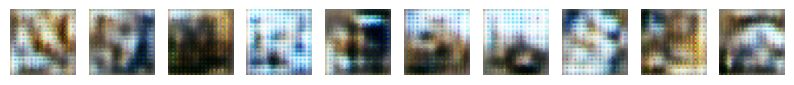

468/468 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - d_loss: 0.4951 - g_loss: 1.4765
Epoch 2/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - d_loss: 0.6721 - g_loss: 0.8569
Epoch 3/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - d_loss: 0.6780 - g_loss: 0.8088
Epoch 4/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - d_loss: 0.6639 - g_loss: 0.8441
Epoch 5/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - d_loss: 0.6796 - g_loss: 0.7945
Epoch 6/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - d_loss: 0.6804 - g_loss: 0.7915
Epoch 7/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - d_loss: 0.6789 - g_loss: 0.8072
Epoch 8/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - d_loss: 0.6818 - g_loss: 0.8075
Epoch 9/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - d_loss: 0.6789 - g_loss: 0.8020
Epoch 10/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - d_loss: 0.6751 - g_loss: 0.8402

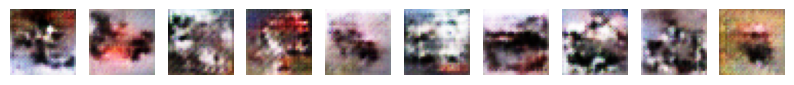

468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - d_loss: 0.6751 - g_loss: 0.8402
Epoch 11/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - d_loss: 0.6729 - g_loss: 0.8493
Epoch 12/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - d_loss: 0.6667 - g_loss: 0.8522
Epoch 13/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - d_loss: 0.6670 - g_loss: 0.8374
Epoch 14/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - d_loss: 0.6717 - g_loss: 0.8238
Epoch 15/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - d_loss: 0.6740 - g_loss: 0.8200
Epoch 16/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - d_loss: 0.6779 - g_loss: 0.8078
Epoch 17/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - d_loss: 0.6794 - g_loss: 0.8046
Epoch 18/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - d_loss: 0.6794 - g_loss: 0.7975
Epoch 19/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - d_loss: 0.6800 - g_loss: 0.7912
Epoch 20/50
467/468 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.6808 - g_loss: 0.7965

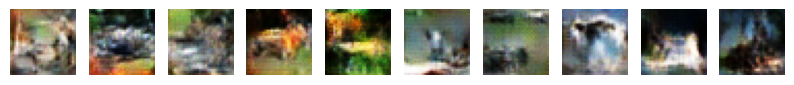

468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - d_loss: 0.6808 - g_loss: 0.7965
Epoch 21/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - d_loss: 0.6788 - g_loss: 0.7968
Epoch 22/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - d_loss: 0.6778 - g_loss: 0.7997
Epoch 23/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - d_loss: 0.6766 - g_loss: 0.8005
Epoch 24/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - d_loss: 0.6740 - g_loss: 0.8059
Epoch 25/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - d_loss: 0.6723 - g_loss: 0.8153
Epoch 26/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - d_loss: 0.6701 - g_loss: 0.8270
Epoch 27/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - d_loss: 0.6685 - g_loss: 0.8232
Epoch 28/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - d_loss: 0.6664 - g_loss: 0.8318
Epoch 29/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - d_loss: 0.6673 - g_loss: 0.8304
Epoch 30/50
467/468 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.6668 - g_loss: 0.8213

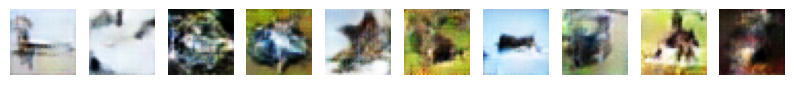

468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - d_loss: 0.6668 - g_loss: 0.8213
Epoch 31/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - d_loss: 0.6671 - g_loss: 0.8209
Epoch 32/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - d_loss: 0.6663 - g_loss: 0.8201
Epoch 33/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - d_loss: 0.6643 - g_loss: 0.8233
Epoch 34/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - d_loss: 0.6652 - g_loss: 0.8292
Epoch 35/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - d_loss: 0.6635 - g_loss: 0.8284
Epoch 36/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - d_loss: 0.6643 - g_loss: 0.8312
Epoch 37/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - d_loss: 0.6633 - g_loss: 0.8286
Epoch 38/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - d_loss: 0.6619 - g_loss: 0.8311
Epoch 39/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - d_loss: 0.6610 - g_loss: 0.8394
Epoch 40/50
467/468 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - d_loss: 0.6587 - g_loss: 0.8424

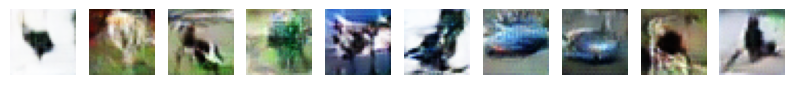

468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - d_loss: 0.6587 - g_loss: 0.8424
Epoch 41/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - d_loss: 0.6578 - g_loss: 0.8436
Epoch 42/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - d_loss: 0.6566 - g_loss: 0.8490
Epoch 43/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - d_loss: 0.6546 - g_loss: 0.8512
Epoch 44/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - d_loss: 0.6536 - g_loss: 0.8513
Epoch 45/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - d_loss: 0.6514 - g_loss: 0.8563
Epoch 46/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - d_loss: 0.6508 - g_loss: 0.8628
Epoch 47/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - d_loss: 0.6490 - g_loss: 0.8668
Epoch 48/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - d_loss: 0.6498 - g_loss: 0.8718
Epoch 49/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - d_loss: 0.6471 - g_loss: 0.8688
Epoch 50/50
467/468 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.6458 - g_loss: 0.8736

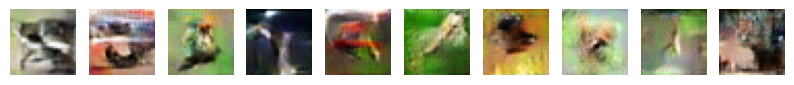

468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - d_loss: 0.6458 - g_loss: 0.8736


In [17]:
conditional_gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
conditional_gan.compile(
    d_optimizer=d_optimizer,
    g_optimizer=g_optimizer,
    loss_fn=loss_fn
)

history = conditional_gan.fit(dataset, epochs=epochs, callbacks=[GANMonitor(all_labels_enc,
                                                                num_img=10,
                                                                latent_dim=latent_dim)])

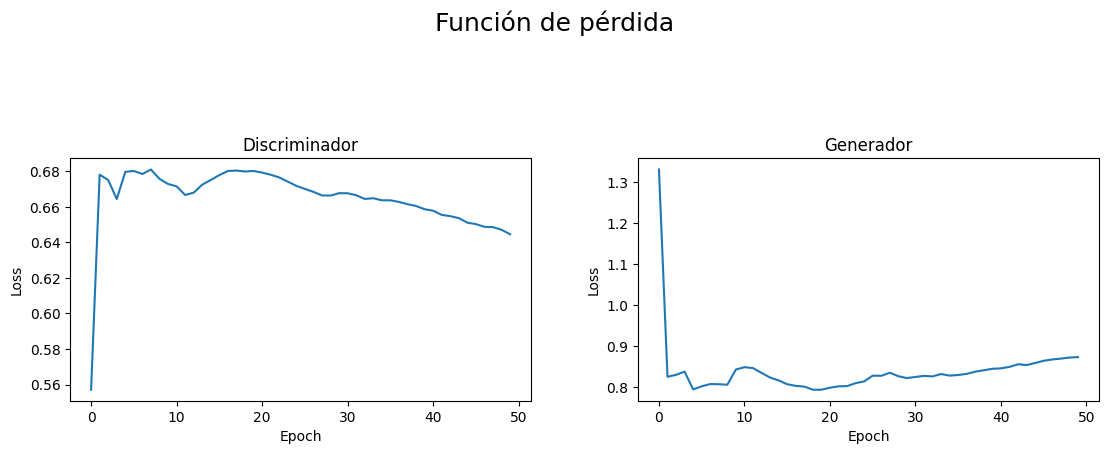

Pérdida discriminador: Min (0.557) Max (0.681) Media (0.665)
Pérdida generador: Min (0.793) Max (1.331) Media (0.839)


In [18]:
plt_loss(history)

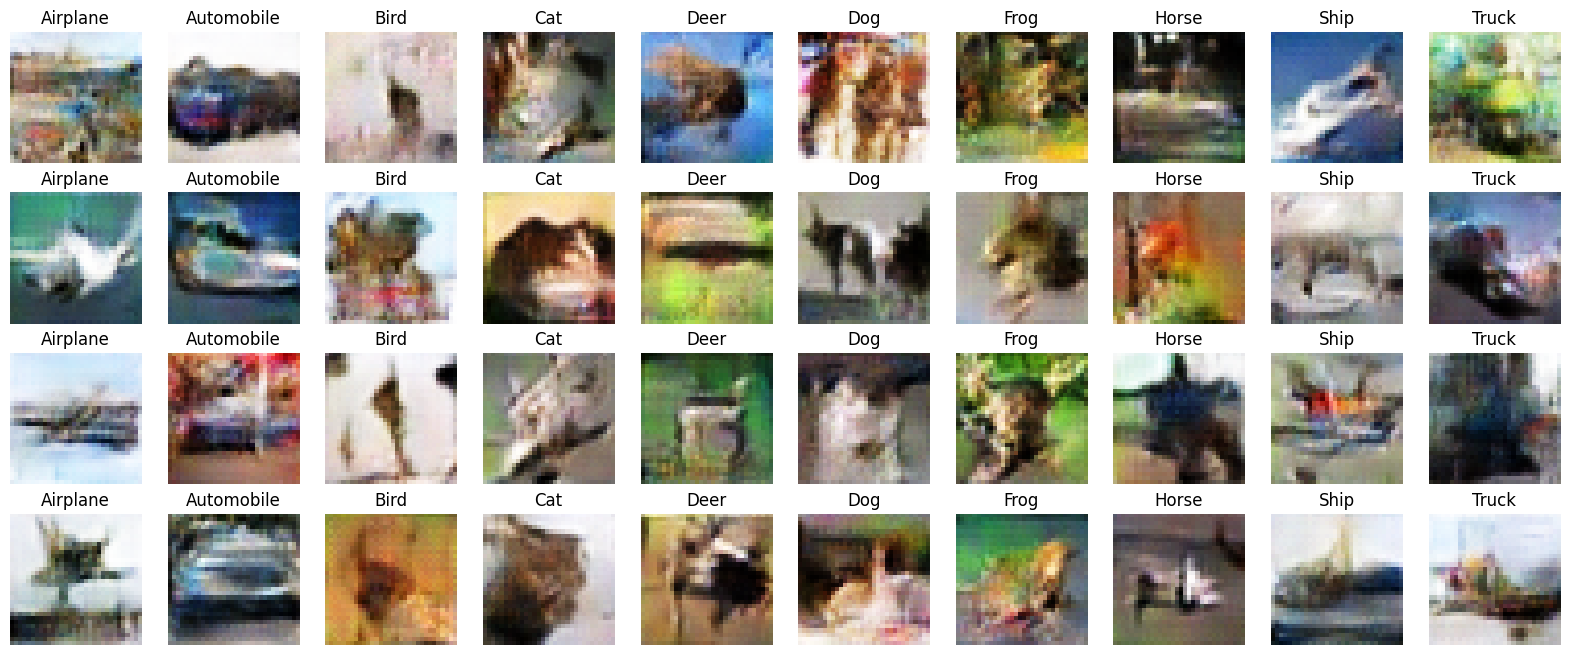

In [23]:
classes_labels = tf.keras.utils.to_categorical([x for x in range(10)] * 4, 10)
classes_labels = tf.convert_to_tensor(classes_labels, dtype=tf.float32) # Convert classes_labels to a TensorFlow tensor

random_latent_vectors = tf.random.normal(shape=(len(classes_labels), latent_dim))
generated_images = conditional_gan.generator([classes_labels,random_latent_vectors])
generated_images = (generated_images + 1) / 2.0

plt.figure(figsize=(20, 8))
plt.subplots_adjust(wspace=0.2, hspace=0.2)
pos = 1
classes_to_int = np.argmax(classes_labels, axis=-1)
for n in range(generated_images.shape[0]):
    plt.subplot(4, 10, pos)
    img = keras.preprocessing.image.array_to_img(generated_images[n])
    plt.imshow(img)
    plt.axis('off')
    plt.title(clases[classes_to_int[n]], size=12)
    pos += 1
plt.show()

#### Resultados
<mark>\[Respuesta: Explicar los resultados obtenidos visualizando y compararlos con los obtenidos en la GAN que se ha utilizado como base y la GAN con *Experience replay*. \]</mark>

**Discriminador**

Arranca en valores entre 0.67–0.68. Muestra una disminución progresiva hasta cerca de ~0.65 al final, lo que indica que el discriminador aprende a distinguir mejor entre imágenes reales y generadas, aunque no de una manera especialmente buena.

Las oscilaciones moderadas que se observan son naturales, ya que son causadas por la adaptación del generador a las respuestas del discriminador.

**Generador**

Comienza alrededor de 1.4 y desciende de manera brusca en las primeras épocas, llegando a ~0.8. Esto implica que el generador encuentra rápido la manera de “engañar” al discriminador.

A partir de este punto, la curva se estabiliza, mostrando un ligero crecimiento hasta valores cercanos a ~0.87. Esto da a entender que, a medida que el discriminador va haciendose más eficaz, el generador tiene cada vez más dificultades para "engañarle"; aunque en este caso no se da con la misma intensidad que con el entrenamiento con _Experience Replay_.

**General**:

Al incluir la etiqueta en el generador y el discriminador, el modelo “sabe” qué tipo de imagen debe producir o evaluar, lo cual acota la tarea y suele mejorar la coherencia de las imágenes generadas.

Esto puede llevar a un rango de valores de pérdida más acotado, ya que el generador no parte totalmente “a ciegas”: la etiqueta ayuda a guiar la generación. Esto se observa por ejemplo con la vurva de pérdida del generador del modelo con _Experience Replay_.

El discriminador por su parte también tiene la etiqueta, por lo tanto dispone de una "pista" adicional para detectar inconsistencias entre la etiqueta y la imagen falsa.

Otro hecho a destacar, es que en el entrenamiento de la conditional DCGAN, la pérdida del generador tiene valores más bajos comparado con el generador de la DCGAN base y la DCGAN con _Experience Replay_.

### Conclusiones finales
<mark>\[Respuesta: Resumir el trabajo realizado y las conclusiones principales que se extraen del mismo. \]</mark>

Se han entrenado diferentes variantes de DCGAN para la generación de imágenes sintéticas usando el conjunto de entrenamiento CIFAR10.

Las estrategias implementadas han consistido en:
- **Preprocesado previo:** Se normaliza el conjunto de datos CIFAR10 dentro del rango [-1, 1]. Esto es necesario ya que se hace uso de la función de activación _Tangente hiperbólica_.
- **DCGAN:** Se implementa una DCGAN base con un generador y un discriminador. El optimizador utilizado para ambas partes de la DCGAN ha sido _Adam_. La función de _Loss_ ha consistido en la _Entropía Cruzada Binaria_.
- **DCGAN con _Experience Replay_:** En busca de mayor estabilidad en el entrenamiento de la DCGAN, se ha implementado esta estrategia, utilizando un _buffer_ por el cual el discriminador recibe como entrada imágenes generadas históricas.
- **Conditional DCGAN:** Se modifica la DCGAN para que permita dirigir la generación de imágenes a partir de una clase seleccionada.

En este trabajo se demuestrá la implementación de los diferentes tipos de GAN. El entrenamiento de estos modelos ha estado limitado a 50 _epochs_, por lo que, probar a aumentar este número, jugar con algunos hiperparámetros (número de capas, filtros y tamaño de kernels, función de activación, optimizador...) o probar otra estrategia de _Experience Replay_ diferente, puede ayudar a encontrar un modelo generador más eficaz en la creación de imágenes sintéticas.

 En resumen, la DCGAN base muestra un entrenamiento relativamente equilibrado donde las pérdidas tanto del generador como del discriminador se estabilizan en rangos moderados; la incorporación de Experience Replay refuerza al discriminador al mantener en memoria ejemplos pasados, lo que reduce su pérdida pero incrementa la del generador, evidenciando un desequilibrio en favor del discriminador; mientras que la versión condicional, al integrar información de etiquetas, guía el aprendizaje de ambos componentes y resulta en curvas de pérdida más estables y acotadas, promoviendo un balance más coherente entre generación y discriminación.



### (Opcional) Cycle-GANs
<mark>\[Respuesta: Buscar información de las *Cycle GANs* y resumir su funcionamiento, haciendo especial énfasis en las novedades que introducen sobre las tipologías vistas en esta práctica . \]</mark>

Las CycleGANs son una variación de las GANs que permiten la traducción de imágenes entre dominios sin necesidad de datos emparejados. Por ejemplo, uma imágen de un caballo más la imagen de una cebra, generará una imagen como la inicial pero habiendo convertido a los caballos en cebras.

En las CycleGANs, se. emplean dos generadores (G: X -> Y y F: Y -> X) y dos discriminadores (D_X y D_Y).

Cada generador transforma imágenes de un dominio a otro, mientras los discriminadores evalúan la autenticidad de las imágenes generadas. Además, para el entrenamiento, no se necesitan pares de imágenes alineadas (p. ej: una foto de un paisaje y su versión artística correspondiente), solo conjuntos de imágenes de cada dominio

**CycleGAN vs DCGAN**

Las DCGAN usan arquitecturas convolucionales profundas para generar imágenes de alta calidad, pero no están diseñadas para la "traducción" entre dominios.

**CycleGAN vs Conditional GAN**

Mientras las conditional GANs necesitan imágenes emparejadas para aprender mapeos específicos, las CycleGANs trabajan con dominios no relacionados (p. ej: caballos con cebras).